# Import Library

In [1]:
!pip install mesa
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
# !pip install community

In [2]:
import networkx as nx
import time, enum, math, random, os
import numpy as np
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Define Classes

In [3]:
class State(enum.IntEnum):
    susceptible = 0
    infected = 1
    immune = 2
    exposed = 3

In [4]:
class MyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.state = State.susceptible
        self.infection_time = 0
        self.recovery_time = 0

    def status(self):
        if self.state == State.infected:           
            t = self.model.schedule.time-self.infection_time
            if t >= self.recovery_time:          
                self.state = State.immune
                return
            self.infect()

    def infect(self):
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if agent.state is State.susceptible
        ]
        for a in susceptible_neighbors:
            random_float = self.random.random() 
            if  random_float < self.model.inf_rate:
                a.state = State.exposed

    def step(self):
        self.status()
        
    def advance(self):
        if self.state == State.exposed:
            self.state = State.infected
            self.recovery_time = self.model.get_recovery_time()
            self.infection_time = self.model.schedule.time

In [5]:
class NetworkInfectionModel(Model):
    """A model for infection spread."""
    def __init__(self, graf, 
                 inf_rate=0.5, 
                 infected=2,
                 recovery_days=21,
                 recovery_sd=7, 
                 num_comms=None,
                 comms=None,
                 num_step=200,
                 kind=''): 
        
        self.num_nodes = len(graf.nodes())  
        self.initial_outbreak_size = infected
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        self.inf_rate = inf_rate
        self.num_step = num_step
        
        self.kind = kind
        self.G = graf
        self.grid = NetworkGrid(self.G)
        self.cmap = ListedColormap(["lightblue", "orange", "green",])
        
        self.num_comms = num_comms
        self.comms = comms            
        
        self.schedule = SimultaneousActivation(self)
        self.running = True

        infected_nodes = random.choices(range(0,self.num_nodes) ,k=self.initial_outbreak_size)
        for i, node in enumerate(self.G.nodes()):
            a = MyAgent(i+1, self)
            self.schedule.add(a)
            self.grid.place_agent(a, node)
            
            if i in infected_nodes:
                a.state = State.infected
                a.recovery_time = self.get_recovery_time()
                a.infection_time = self.schedule.time
                
        self.datacollector = DataCollector(agent_reporters={"State": "state"})

    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        
    def get_column_data(self):
        #pivot the model dataframe to get states count at each step
        agent_state = self.datacollector.get_agent_vars_dataframe()
        X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
        labels = ['Susceptible','Infected','Removed']
        X.columns = labels[:len(X.columns)]
        return X

    def plot_states(self,ax):    
        steps = self.schedule.steps
        X = self.get_column_data()
        X.plot(ax=ax,lw=3,alpha=0.8)
        return ax
    
    def run_by_steps(self):
        for _ in range(self.num_step):
            self.step()
            
    def plot_network(self,ax,title=''):
        if self.comms==None:
            nx.draw(self.G, self.pos, node_size=80, edge_color='gray', node_color="lightblue", 
                    alpha=0.9,font_size=100,ax=ax)
        else:
            states = [int(i.state) for i in model.grid.get_all_cell_contents()]
            nx.draw_networkx_edges(self.G, self.pos, alpha=0.5,ax=ax)
            warna = plt.cm.get_cmap('hsv',self.num_comms)
            for node, color in self.comms.items():
                nx.draw_networkx_nodes(self.G, self.pos, [node], node_size=100,
                                    node_color=[warna(color)],ax=ax)
        ax.set_title(title,fontsize=30)
        return ax

In [6]:
def create_small_world_network(pop,node_degree,beta=0.5):
    g = nx.watts_strogatz_graph(n = pop, k = node_degree, p = beta)
    return g

def create_random_network(pop,avg_degree,seed=None):
    p_random = avg_degree/pop
    g = nx.erdos_renyi_graph(n=pop, p=p_random,seed=seed)
    return g

def create_lattice_network(row,col,node_degree,periodic=True):
    if node_degree == 2:
        g = create_small_world_network(row*col,2,beta=0)
    elif node_degree == 3:
        g = nx.hexagonal_lattice_graph(row,col,periodic=periodic)

    elif node_degree == 4:
        g = nx.grid_2d_graph(row,col)

    elif node_degree == 6:
        g = nx.triangular_lattice_graph(row,col,periodic=periodic)

    elif node_degree == 8:
        g = nx.grid_2d_graph(row,col)
        for i in range(row-1):
            for j in range(col-1):
                g.add_edge((i,j),(i+1,j+1))
                g.add_edge((i,j+1),(i+1,j))
    else:
        raise "Salah degree"
    return g

def create_scale_free_network(pop,m):
    g = nx.barabasi_albert_graph(pop,m)
    return g

def create_community_network(num_comms,num_nodes,avg_deg,p_out=None):
    p_in = avg_deg / num_nodes
    p_out = 1/(num_comms*num_nodes*3)
#     if p_out == None: p_out  = 0.005
    g = nx.planted_partition_graph(num_comms,num_nodes,p_in,p_out)
    return g,pos,find_community(g,num_comms)

def find_community(graph,num_comms):
    c = best_partition(graph)
    c_nodes = comm_nodes(c)
    l = [(c[i],i) for i in c]
    val = list(c.values())
    hasil = [(val.count(i),i) for i in set(val)]
    hasil.sort()
    max_ = hasil[-num_comms:]
    sisa = hasil[:-num_comms]
    a = []
    while sisa:
        i,j = sisa.pop(0)
        k,l = max_[0]
        a.append((j,l))
        max_[0] = (k+i,l)
        max_.sort()
    for i,j in a:
        u = [k for k in c if c[k] == i]
        for l in u:
            c[l] = j
            penghubung = random.choice(c_nodes[j])
            graph.add_edge(penghubung,l)
    val = list(c.values())
    hasil = [(val.count(i),i) for i in set(val)]
    hasil.sort()
    last = [i[1] for i in hasil]
    for i in c:
        c[i] = last.index(c[i])
    val = list(c.values())
    hasil = [(val.count(i),i) for i in set(val)]
    hasil.sort()
    return c

def comm_nodes(d):
    # tujuan: dari {1:1,2:1,3:1} --> {1:[1,2,3]}
    hasil = {i:[] for i in set(d.values())}
    for i in d:
        hasil[d[i]].append(i)
    return hasil

def save_figure(fig,directory,filename):
    isExist = os.path.exists(directory)
    if not isExist:
        os.makedirs(directory)
        print("The new directory is created!")
    fig.savefig(directory+"/"+filename+".png")
    print(directory+"/"+filename+".png"+" created!")


# Table History

In [7]:
def get_history_from_100_model(graph,inf_rate,step=200):
    list_max_infected = []
    for j in range(100):
        model = NetworkInfectionModel(graph,inf_rate)
        for k in range(step):
            model.step()
        df = model.get_column_data().reset_index()
        df.insert(loc=0,column='model',value=[j]*step)
        list_max_infected.append(df)
    return pd.concat(list_max_infected)

In [9]:
# Parameter sebenarnya
N_list = [1000,10000]
k_list = [2,3,4,6,8]
row_col = [[(1,1000),(5,100),(25,40),(39,48),(25,40)],
           [(1,10000),(50,100),(100,100),(124,158),(100,100)]]
inf_rate_list = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
step=500

# Cuma untuk coba" (nanti bisa di #)
# N_list = [50,100]
# k_list = [2,4]
# inf_rate_list = [.1,.2,.5,1]
# row_col = [[(1,50),(5,10)],
#            [(1,100),(10,10)]]
# step=100

history_table=[]
start_time = time.time()
print("Starting... ")
for N in range(1,len(N_list)):
    point_time_N = time.time()
    df_list_k = []
    
    for k in range(len(k_list)):
        point_time_k = time.time()
        df_list_inf_rate = []
        
        for inf_rate in inf_rate_list:
            point_time_inf_rate = time.time()
            print(f"Getting data N={N_list[N]} k={k_list[k]} inf_rate={inf_rate} at {time.time()-start_time}")
            row,col = row_col[N][k]
            graph = create_lattice_network(row,col,k_list[k]) # Ubah Create Grafnya Sesuain dengan graf masing"
            df = get_history_from_100_model(graph,inf_rate,step)
            row_num = df.shape[0]
            df.insert(loc=0,column='inf_rate',value=[inf_rate]*row_num)
            df_list_inf_rate.append(df)
            print(f"Have got data N={N_list[N]} k={k_list[k]} inf_rate={inf_rate} in {round(time.time()-point_time_inf_rate,3)}s")
            
        df = pd.concat(df_list_inf_rate)
        row_num = df.shape[0]
        df.insert(loc=0,column='k',value=[k_list[k]]*row_num)
        df_list_k.append(df)
        print(f"Have got data N={N_list[N]} k={k_list[k]} in {round(time.time()-point_time_k,3)}s")
        
    df = pd.concat(df_list_k)
    row_num = df.shape[0]
    df.insert(loc=0,column='N',value=[N_list[N]]*row_num)
    history_table.append(df)
    print(f"Have got data N={N_list[N]} in {round(time.time()-point_time_N,3)}s")
    
history_table = pd.concat(history_table)
display(history_table)

print("Saving csv...")
history_table.to_csv("History_table.csv",index=False)

print("Finished ✨")
print(f"Creating history table take {round(time.time()-start_time,3)}s")



Starting... 
Getting data N=10000 k=2 inf_rate=0.1 at 0.0
Have got data N=10000 k=2 inf_rate=0.1 in 966.237s
Getting data N=10000 k=2 inf_rate=0.2 at 966.2366781234741
Have got data N=10000 k=2 inf_rate=0.2 in 979.371s
Getting data N=10000 k=2 inf_rate=0.3 at 1945.6075224876404
Have got data N=10000 k=2 inf_rate=0.3 in 988.406s
Getting data N=10000 k=2 inf_rate=0.4 at 2934.0132825374603
Have got data N=10000 k=2 inf_rate=0.4 in 994.564s
Getting data N=10000 k=2 inf_rate=0.5 at 3928.5772745609283
Have got data N=10000 k=2 inf_rate=0.5 in 999.777s
Getting data N=10000 k=2 inf_rate=0.6 at 4928.354701519012
Have got data N=10000 k=2 inf_rate=0.6 in 1001.749s
Getting data N=10000 k=2 inf_rate=0.7 at 5930.103268861771
Have got data N=10000 k=2 inf_rate=0.7 in 1004.445s
Getting data N=10000 k=2 inf_rate=0.8 at 6934.5479300022125
Have got data N=10000 k=2 inf_rate=0.8 in 1005.573s
Getting data N=10000 k=2 inf_rate=0.9 at 7940.120639801025
Have got data N=10000 k=2 inf_rate=0.9 in 1010.436s
Get

,N,k,inf_rate,model,Step,Susceptible,Infected,Removed
0,10000,2,0.1,0,0,9998,2,0
1,10000,2,0.1,0,1,9998,2,0
2,10000,2,0.1,0,2,9997,3,0
3,10000,2,0.1,0,3,9996,4,0
4,10000,2,0.1,0,4,9995,5,0
...,...,...,...,...,...,...,...,...
495,10000,8,1.0,99,495,0,0,10000
496,10000,8,1.0,99,496,0,0,10000
497,10000,8,1.0,99,497,0,0,10000
498,10000,8,1.0,99,498,0,0,10000


Saving csv...
Finished ✨
Creating history table take 408156.202s


# Box Plot Table & Heap Table

In [10]:
ht = history_table
jumlah_baris_dalam_model = step
jumlah_baris_dalam_inf_rate = jumlah_baris_dalam_model*100
jumlah_baris_dalam_k = jumlah_baris_dalam_inf_rate*len(inf_rate_list)
jumlah_baris_dalam_N = jumlah_baris_dalam_k*len(k_list)
# print(jumlah_baris_dalam_model)
# print(jumlah_baris_dalam_inf_rate)
# print(jumlah_baris_dalam_k)
# print(jumlah_baris_dalam_N)

df_i_list_box = []
df_i_list_heap = []
for i in range(len(N_list)):
    df_i = ht[jumlah_baris_dalam_N*i:jumlah_baris_dalam_N*(i+1)]
    df_j_list_box = []
    df_j_list_heap = []

    for j in range(len(k_list)):
        df_j = df_i[jumlah_baris_dalam_k*j:jumlah_baris_dalam_k*(j+1)]
        df_k_list_box = []
        df_k_list_heap = []
        
        for k in range(len(inf_rate_list)):
            df_k = df_j[jumlah_baris_dalam_inf_rate*k:jumlah_baris_dalam_inf_rate*(k+1)]
            df_l_list_box = []
            
            for l in range(100):
                df_l = df_k[jumlah_baris_dalam_model*l:jumlah_baris_dalam_model*(l+1)]
                df_l = df_l[df_l["Infected"] == df_l["Infected"].max()]
                df_l = df_l.loc[:,["Infected","Step"]].iloc[:1,:]
                df_l_list_box.append(df_l)
                
            df = pd.concat(df_l_list_box).reset_index().reset_index().drop(columns=['index'])
            df = df.rename(columns={"level_0":"model","Infected":"max_inf","Step":"t_max"})
            row_num = df.shape[0]
            df.insert(loc=0,column='inf_rate',value=[inf_rate_list[k]]*row_num)
            df_k_list_heap.append([inf_rate_list[k],df["max_inf"].max(),df["max_inf"].mean(),df["t_max"].max(),df["t_max"].mean()])
            df_k_list_box.append(df)
        
        
        df_j_box = pd.concat(df_k_list_box)
        row_num = df_j_box.shape[0]
        df_j_box.insert(loc=0,column='k',value=[k_list[j]]*row_num)
        df_j_list_box.append(df_j_box)
        
        df_j_heap = pd.DataFrame(df_k_list_heap,columns=["inf_rate","max_inf(max)","max_inf(mean)","t_max(max)","t_max(mean)"])
        row_num = df_j_heap.shape[0]
        df_j_heap.insert(loc=0,column='k',value=[k_list[j]]*row_num)
        df_j_list_heap.append(df_j_heap)
        
    df_i_box = pd.concat(df_j_list_box)
    row_num = df_i_box.shape[0]
    df_i_box.insert(loc=0,column='N',value=[N_list[i]]*row_num)
    df_i_list_box.append(df_i_box)
    
    df_i_heap = pd.concat(df_j_list_heap)
    row_num = df_i_heap.shape[0]
    df_i_heap.insert(loc=0,column='N',value=[N_list[i]]*row_num)
    df_i_list_heap.append(df_i_heap)
    
df_box = pd.concat(df_i_list_box)
df_heap = pd.concat(df_i_list_heap)



print("Saving csv...")
df_box.to_csv("Box_plot_table.csv",index=False)
df_heap.to_csv("Heap_map_table.csv",index=False)

print("Finished ✨")
display(df_box)
display(df_heap)

    

            

Saving csv...
Finished ✨


,N,k,inf_rate,model,max_inf,t_max
0,1000.0,2.0,0.1,0,14,78
1,1000.0,2.0,0.1,1,9,14
2,1000.0,2.0,0.1,2,8,20
3,1000.0,2.0,0.1,3,9,15
4,1000.0,2.0,0.1,4,7,16
...,...,...,...,...,...,...
95,1000.0,8.0,1.0,95,4183,37
96,1000.0,8.0,1.0,96,3504,41
97,1000.0,8.0,1.0,97,3481,30
98,1000.0,8.0,1.0,98,2874,37


,N,k,inf_rate,max_inf(max),max_inf(mean),t_max(max),t_max(mean)
0,1000,2,0.1,16.0,9.32,78.0,22.24
1,1000,2,0.2,31.0,18.11,142.0,35.89
2,1000,2,0.3,41.0,28.38,290.0,56.13
3,1000,2,0.4,48.0,36.03,301.0,61.71
4,1000,2,0.5,58.0,45.78,208.0,61.33
...,...,...,...,...,...,...,...
5,10000,8,0.6,NaN,NaN,NaN,NaN
6,10000,8,0.7,NaN,NaN,NaN,NaN
7,10000,8,0.8,NaN,NaN,NaN,NaN
8,10000,8,0.9,NaN,NaN,NaN,NaN


# History

# HeapMap

In [11]:
df_heap_50 = df_heap[df_heap.N == 50]
MIMax = df_heap_50.loc[:,["k","max_inf(max)"]].set_index(df_heap_50.inf_rate)
MIMax = pd.concat((MIMax[MIMax.k==2],MIMax[MIMax.k==4]),axis=1).drop(columns=["k"])

MIMean = df_heap_50.loc[:,["k","max_inf(mean)"]].set_index(df_heap_50.inf_rate)
MIMean = pd.concat((MIMean[MIMean.k==2],MIMean[MIMean.k==4]),axis=1).drop(columns=["k"])

TMMax = df_heap_50.loc[:,["k","t_max(max)"]].set_index(df_heap_50.inf_rate)
TMMax = pd.concat((TMMax[TMMax.k==2],TMMax[TMMax.k==4]),axis=1).drop(columns=["k"])

TMMean = df_heap_50.loc[:,["k","t_max(mean)"]].set_index(df_heap_50.inf_rate)
TMMean = pd.concat((TMMean[TMMean.k==2],TMMean[TMMean.k==4]),axis=1).drop(columns=["k"])


ValueError: zero-size array to reduction operation fmin which has no identity

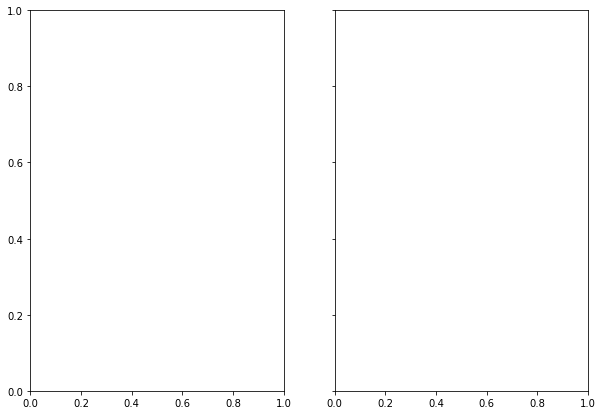

In [12]:
fig,axes = plt.subplots(1,2,figsize=(10,7),sharex=True,sharey=True)

ax1 = sns.heatmap(MIMax , linewidth = 0.5 ,annot = True, cmap = 'coolwarm',fmt='g',ax=axes[0])
ax2 = sns.heatmap(MIMean , linewidth = 0.5 ,annot = True, cmap = 'coolwarm',fmt='g',ax=axes[1])

plt.suptitle("Heapmap Max Infected (max & mean) ")
ax1.set_yticklabels(df_heap_50["inf_rate"].unique())
ax1.set_xticklabels(df_heap_50["k"].unique())
ax2.set_yticklabels(df_heap_50["inf_rate"].unique())
ax2.set_xticklabels(df_heap_50["k"].unique())
ax1.set_xlabel("Degree")
ax2.set_xlabel("Degree")
plt.show()

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(10,10),sharex=True)
ax1 = sns.heatmap(TMMax , linewidth = 0.5 ,annot = True, cmap = 'coolwarm',fmt='g',ax=axes[0])
ax2 = sns.heatmap(TMMean , linewidth = 0.5 ,annot = True, cmap = 'coolwarm',fmt='g',ax=axes[1])

plt.suptitle("Heapmap Time Max Infected (max & mean) ")
ax1.set_yticklabels(df_heap_50["inf_rate"].unique())
ax1.set_xticklabels(df_heap_50["k"].unique())
ax2.set_yticklabels(df_heap_50["inf_rate"].unique())
ax2.set_xticklabels(df_heap_50["k"].unique())
ax1.set_xlabel("Degree")
ax2.set_xlabel("Degree")
plt.show()

# Box Plot

In [ ]:
df_box_50 = df_box[df_box.N == 50]

In [ ]:
fig,ax = plt.subplots(figsize=(12,20))
df_heap
sns.set(font_scale = 1.5,style="whitegrid")
ax = sns.boxplot(x='max_inf',y='k',data=df_box_50,hue='inf_rate',ax=ax,orient='h')
plt.grid()
plt.title("BoxPlot Lattice N=50",fontsize=20)
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(12,20))
df_heap
sns.set(font_scale = 1.5,style="whitegrid")
ax = sns.boxplot(x='t_max',y='k',data=df_box_50,hue='inf_rate',ax=ax,orient='h')
plt.grid()
plt.title("BoxPlot Lattice N=50 (time)",fontsize=20)
plt.show()